In [1]:
from collections import Counter
import os

from easyfsl.utils import plot_images, sliding_average
from torchvision.datasets import Omniglot
from easyfsl.samplers import TaskSampler
from torch.utils.data import DataLoader
from torchvision.models import resnet18
from torchvision import transforms
import matplotlib.pyplot as plt
from torch import nn, optim
from tqdm import tqdm
import numpy as np
import torch

In [2]:
image_size = 28

In [3]:
train_set = Omniglot(
                
                root       = './data',
                background = True,
                transform  = transforms.Compose([
                                transforms.Grayscale(num_output_channels = 3),
                                transforms.RandomResizedCrop(image_size),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                            ]),
                download   = True,
            )

test_set = Omniglot(
            root       = './data',
            background = False,
            transform  = transforms.Compose([
                            transforms.Grayscale(num_output_channels = 3),
                            transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
                            transforms.CenterCrop(image_size),
                            transforms.ToTensor()
                        ]),
            download    = True
    
        )

Files already downloaded and verified
Files already downloaded and verified


In [4]:
labels = [instance[1] for instance in train_set._flat_character_images]
labels = set(labels)

In [5]:
class BaseResNet18(nn.Module):
    
    def __init__(self, n_classes = len(labels)):
        
        super(BaseResNet18, self).__init__()
        self.base_model    = resnet18(pretrained = True)
        in_features        = self.base_model.fc.in_features
        self.base_model.fc = nn.Linear(in_features, n_classes)
        
        
    def forward(self, x):
        
        output = self.base_model(x)
        return output

In [6]:
train_loader = DataLoader(train_set, batch_size = 64, shuffle = True)
test_loader  = DataLoader(test_set,  batch_size  = 64, shuffle = True)

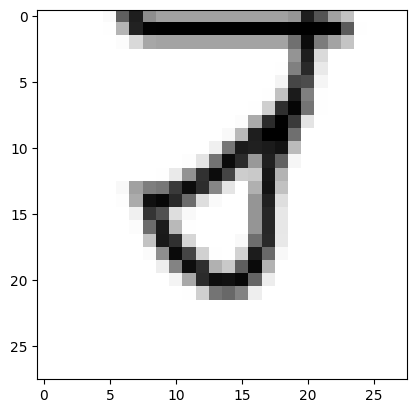

In [7]:
train_image, train_lb = next(iter(train_loader))
plt.imshow(np.transpose(train_image[0].detach().cpu().numpy(), (1, 2, 0)))

In [8]:
def train(model, data_loader, optimizer):
    
    model.train()
    total_loss, correct = 0, 0
    gt, predicted       = [], []
    
    for (images, labels) in tqdm(data_loader):
        
        images, labels = images.float().cuda(), labels.cuda()
        outputs        = model(images)
        loss           = criterion(outputs, labels.data)
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
        
        _, preds    = torch.max(outputs, 1)
        predicted  += preds.detach().cpu().numpy().tolist()
        gt         += labels.detach().cpu().numpy().tolist()
        
        correct    += torch.sum(preds == labels)
        total_loss += loss
        
    avg_loss = total_loss / len(train_loader)
    accuracy = correct / (len(train_loader) * 64)
    
    avg_loss = float(avg_loss.detach().cpu().numpy())
    accuracy = float(accuracy.detach().cpu().numpy())
    
    print(f'[TRAIN] accuracy : {accuracy:.2f} | average loss : {avg_loss:.2f}')
    
    return accuracy    


def run(model, train_loader, optimizer):
    
    best_accu = -1
    for epoch in range(10):
        print(f'[{epoch + 1} / 10]')
        
        train_acc = train(model, train_loader, optimizer)

In [9]:
model = BaseResNet18().cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

run(model, train_loader, optimizer)

/opt/conda/envs/tensor/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/tensor/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[1 / 10]


100%|██████████| 302/302 [00:15<00:00, 20.05it/s]


[TRAIN] accuracy : 0.00 | average loss : 6.99
[2 / 10]


100%|██████████| 302/302 [00:12<00:00, 25.00it/s]


[TRAIN] accuracy : 0.02 | average loss : 5.73
[3 / 10]


100%|██████████| 302/302 [00:12<00:00, 24.56it/s]


[TRAIN] accuracy : 0.05 | average loss : 4.97
[4 / 10]


100%|██████████| 302/302 [00:12<00:00, 24.86it/s]


[TRAIN] accuracy : 0.10 | average loss : 4.44
[5 / 10]


100%|██████████| 302/302 [00:12<00:00, 24.85it/s]


[TRAIN] accuracy : 0.14 | average loss : 4.07
[6 / 10]


100%|██████████| 302/302 [00:12<00:00, 24.54it/s]


[TRAIN] accuracy : 0.18 | average loss : 3.81
[7 / 10]


100%|██████████| 302/302 [00:12<00:00, 24.83it/s]


[TRAIN] accuracy : 0.21 | average loss : 3.60
[8 / 10]


100%|██████████| 302/302 [00:12<00:00, 24.77it/s]


[TRAIN] accuracy : 0.25 | average loss : 3.39
[9 / 10]


100%|██████████| 302/302 [00:12<00:00, 24.37it/s]


[TRAIN] accuracy : 0.26 | average loss : 3.35
[10 / 10]


100%|██████████| 302/302 [00:12<00:00, 24.80it/s]


[TRAIN] accuracy : 0.30 | average loss : 3.10


In [10]:
def evaluation(model, test_loader):
    
    model.eval()
    total_loss, correct = 0, 0
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            
            images      = images.float().cuda()
            labels      = labels.cuda()
            
            outputs     = model(images)
            total_loss += criterion(outputs, labels.data)
            
            _, preds    = torch.max(outputs, 1)
            correct    += torch.sum(preds == labels)
            
    avg_loss = total_loss / len(test_loader)
    accuracy = correct   / (len(test_loader) * 64)
    
    avg_loss = float(avg_loss.detach().cpu().numpy())
    accuracy = float(accuracy.detach().cpu().numpy())
    
    print(f'[VALID] accuracy : {accuracy:.2f} | average loss : {avg_loss:.2f}')
    
    
evaluation(model, test_loader)

100%|██████████| 206/206 [00:05<00:00, 40.57it/s]

[VALID] accuracy : 0.00 | average loss : 18.12


In [11]:
class PrototypicalNetworks(nn.Module):
    
    def __init__(self, backbone):
        
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone
        
    
    def forward(self, support_image, support_label, query_image):
        
        z_support = self.backbone.forward(support_image)
        z_query   = self.backbone.forward(query_image)
        
        n_way     = len(torch.unique(support_label))
        z_proto   = torch.cat([
                                z_support[torch.nonzero(support_label == label)].mean(0)
                                for label in range(n_way)
                            ])
        
        dists    = torch.cdist(z_query, z_proto)
        score    = -dists
        
        return score
    

backbone    = resnet18(pretrained = True)
backbone.fc = nn.Flatten()
model       = PrototypicalNetworks(backbone).cuda()

In [12]:
N_EVALUATION_TASKS = 100
N_QUERIES          = 10
N_SHOTS            = 5
N_WAYS             = 5

In [13]:
test_set.get_labels = lambda: [
                                instance[1] for instance in test_set._flat_character_images
                            ]

test_sampler        =  TaskSampler(
                            test_set, n_way = N_WAYS,
                            n_shot  = N_SHOTS, n_query = N_QUERIES,
                            n_tasks = N_EVALUATION_TASKS 
                        )

test_loader         = DataLoader(
                        test_set, batch_sampler = test_sampler,
                        num_workers = 12, pin_memory = True,
                        collate_fn  = test_sampler.episodic_collate_fn
                    )

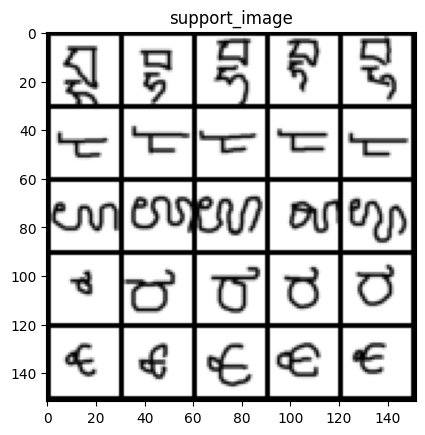

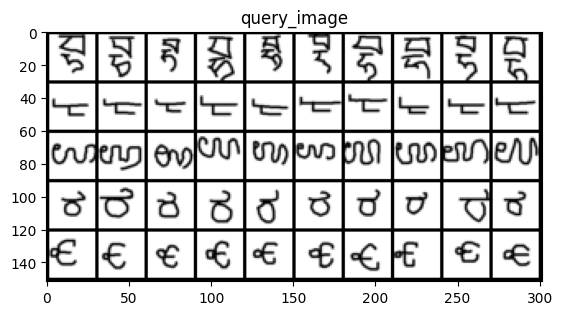

In [14]:
( 
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(test_loader))

plot_images(example_support_images, 'support_image', images_per_row = N_SHOTS)
plot_images(example_query_images  , 'query_image'  , images_per_row = N_QUERIES)

In [15]:
model.eval()

example_score = model(
                        example_support_images.cuda(),
                        example_support_labels.cuda(),
                        example_query_images.cuda()
                     ).detach()

_, example_predicted_labels = torch.max(example_score.data, 1)
for idx, pred_lb in enumerate(example_predicted_labels):
    
    query = test_set._characters[example_class_ids[example_query_labels[idx]]]
    pred  = test_set._characters[example_class_ids[pred_lb]]
    
    print(f'{idx} {query} / {pred}')

0 Tibetan/character23 / Tibetan/character23
1 Tibetan/character23 / Tibetan/character23
2 Tibetan/character23 / Tibetan/character23
3 Tibetan/character23 / Tibetan/character23
4 Tibetan/character23 / Tibetan/character23
5 Tibetan/character23 / Tibetan/character23
6 Tibetan/character23 / Tibetan/character23
7 Tibetan/character23 / Tibetan/character23
8 Tibetan/character23 / Tibetan/character23
9 Tibetan/character23 / Tibetan/character23
10 Keble/character01 / Keble/character01
11 Keble/character01 / Keble/character01
12 Keble/character01 / Keble/character01
13 Keble/character01 / Keble/character01
14 Keble/character01 / Keble/character01
15 Keble/character01 / Keble/character01
16 Keble/character01 / Keble/character01
17 Keble/character01 / Keble/character01
18 Keble/character01 / Keble/character01
19 Keble/character01 / Keble/character01
20 Kannada/character06 / Kannada/character06
21 Kannada/character06 / Kannada/character06
22 Kannada/character06 / Kannada/character06
23 Kannada/char

In [16]:
def evaluate_on_one_task(support_image, support_label, query_image, query_label):
    
    support_image = support_image.cuda()
    support_label = support_label.cuda()
    
    query_image   = query_image.cuda()
    query_label   = query_label.cuda()
    
    pred_score = model(support_image, support_label, query_image)
    pred_score = torch.max(pred_score.detach().data, 1)[1]
    
    return (pred_score == query_label).sum().item(), len(query_label)


def evaluate(data_loader):
    
    total_preds   = 0
    correct_preds = 0
    
    model.eval()
    with torch.no_grad():
        
        for episode_idx, (support_img, support_lb, query_img, query_lb, class_id) \
            in tqdm(enumerate(data_loader), total = len(data_loader)):
            
            correct, total = evaluate_on_one_task(
                                support_img, support_lb,
                                query_img  , query_lb
                            )
            
            total_preds   += total
            correct_preds += correct
            
    print(f'Model tested on {len(data_loader)} tasks.\
          Accuracy {(100 * correct_preds / total_preds):.2f}%')
    
    
evaluate(test_loader)

100%|██████████| 100/100 [00:01<00:00, 79.85it/s]

Model tested on 100 tasks.          Accuracy 86.58%


In [17]:
N_TRAINING_EPISODES = 40000
N_VALIDATION_TASKS  = 100

train_set.get_labels = lambda: [instance[1] for instance in 
                                train_set._flat_character_images]

train_sampler        = TaskSampler(
                            train_set, n_way = N_WAYS, n_shot = N_SHOTS,
                            n_query = N_QUERIES, n_tasks = N_TRAINING_EPISODES
                        )

train_loader         = DataLoader(
                            train_set,
                            batch_sampler = train_sampler,
                            num_workers   = 12,
                            pin_memory    = True,
                            collate_fn    = train_sampler.episodic_collate_fn,
                        )


In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

def fit(support_image, support_label, query_image, query_label):
    
    optimizer.zero_grad()
    support_image = support_image.cuda()
    support_label = support_label.cuda()
    
    query_image   = query_image.cuda()
    query_label   = query_label.cuda()
    
    pred_score = model(support_image, support_label, query_image)
    loss       = criterion(pred_score, query_label)
    
    loss.backward()
    optimizer.step()
    
    return loss.item()

In [19]:
log_update_frequency = 10
all_loss = []
model.train()

with tqdm(enumerate(train_loader), total = len(train_loader)) as tqdm_train:
    
    for episode_idx, (support_img, support_lb, query_img, query_lb, _) \
        in tqdm_train:
            
            loss_value = fit(support_img, support_lb, query_img, query_lb)
            all_loss.append(loss_value)
            
            if episode_idx % log_update_frequency == 10:
                
                tqdm_train.set_postfix(loss = sliding_average(all_loss, log_update_frequency))
                

100%|██████████| 40000/40000 [19:03<00:00, 34.98it/s]


In [20]:
evaluate(test_loader)

100%|██████████| 100/100 [00:01<00:00, 84.90it/s] 

Model tested on 100 tasks.          Accuracy 94.18%
